In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels para inferência
import statsmodels.api as sm
from statsmodels.formula.api import logit
from patsy import dmatrices

# scikit-learn para predição
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import acuracyclassification_report, confusion_matrix, roc_auc_score, roc_curve

# Configurações
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Carregar dados
df = pd.read_csv('coronarias.csv', sep=';')

# Visualizar estrutura
print(df.head())
print(df.info())
print(df.describe())

   Index-original  SEXO  AH3  INFARTO  ANGEST  DIAB  ARTER  ARRIT  TABAG4  \
0               3     1    0        0       0   0.0    0.0      0     NaN   
1               5     1    0        1       0   0.0    0.0      0     0.0   
2               7     1    1        0       0   0.0    0.0      0     0.0   
3               9     1    1        1       0   1.0    0.0      0     2.0   
4              12     0    2        1       0   1.0    2.0      0     0.0   

   OBESO  IDADE1  ALTURA  PESO    IMC    COL   TRIG   PSR   PDR  GLO  
0    0.0    28.0    1.69  62.0  21.71  213.0  136.0  12.0   8.0    0  
1    0.0    64.0    1.80  87.0  26.85  184.0  110.0  13.0   8.0    0  
2    0.0    44.0    1.70  60.0  20.76    NaN  243.0  13.0   6.0    1  
3    0.0    62.0    1.81  80.0  24.42  255.0  324.0  17.0   8.0    0  
4    0.0    30.0    1.65  70.0  25.71  220.0  189.0  16.0  10.0    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   C

In [2]:
# Opção 1: Remover linhas com missing
df_clean = df.dropna()

variaveis_numericas = ['IDADE1', 'ALTURA', 'PESO', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG']
variaveis_categoricas =['SEXO', 'DIAB', 'AH3', 'ANGEST', 'ARTER', 'ARRIT', 'OBESO', 'TABAG4', 'INFARTO','GLO']

In [ ]:

# Calcular matriz de correlação (apenas numéricas)
correlation_matrix = df[variaveis_numericas].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

# VIF (Variance Inflation Factor) - método mais robusto
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = df[variaveis_numericas]
vif_data = pd.DataFrame()
vif_data["Variavel"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]

print(vif_data)
# VIF > 10 indica multicolinearidade problemática
# VIF > 5 merece atenção


'\n# Calcular matriz de correlação (apenas numéricas)\ncorrelation_matrix = df[variaveis_numericas].corr()\n\n# Visualizar\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', center=0)\nplt.title(\'Matriz de Correlação\')\nplt.show()\n\n# VIF (Variance Inflation Factor) - método mais robusto\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\nX_num = df[variaveis_numericas]\nvif_data = pd.DataFrame()\nvif_data["Variavel"] = X_num.columns\nvif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]\n\nprint(vif_data)\n# VIF > 10 indica multicolinearidade problemática\n# VIF > 5 merece atenção\n'

In [4]:
"""
# Exemplo: População tem valores muito maiores que Idade
# Aplicar log em variáveis com grande amplitude
df['log_populacao'] = np.log(df['populacao'] + 1)  # +1 para evitar log(0)

# Ou padronizar (necessário para scikit-learn se solvers como 'sag' ou 'saga')
scaler = StandardScaler()
df[['idade_scaled', 'renda_scaled']] = scaler.fit_transform(df[['idade', 'renda']])
"""

"\n# Exemplo: População tem valores muito maiores que Idade\n# Aplicar log em variáveis com grande amplitude\ndf['log_populacao'] = np.log(df['populacao'] + 1)  # +1 para evitar log(0)\n\n# Ou padronizar (necessário para scikit-learn se solvers como 'sag' ou 'saga')\nscaler = StandardScaler()\ndf[['idade_scaled', 'renda_scaled']] = scaler.fit_transform(df[['idade', 'renda']])\n"

In [5]:

# One-Hot Encoding (cria dummies)
#df_encoded = pd.get_dummies(df, columns=variaveis_categoricas, drop_first=True)
# drop_first=True evita multicolinearidade perfeita (dummy trap)

#print(df_encoded.columns)

In [6]:
"""
# Para cada variável contínua, verificar relação com log-odds
# Método: Box-Tidwell Test (complexo) ou inspeção visual

# Visualização simples: binning + taxa de evento
df['idade_bin'] = pd.cut(df['idade'], bins=10)
taxa_evento = df.groupby('idade_bin')['variavel_dependente'].mean()

plt.figure(figsize=(10, 6))
taxa_evento.plot(kind='line', marker='o')
plt.title('Taxa de Evento por Faixa de Idade')
plt.ylabel('Taxa de Evento')
plt.xlabel('Idade')
plt.xticks(rotation=45)
plt.show()

# Se não for linear, considere transformações: log, polinomial, splines
"""

"\n# Para cada variável contínua, verificar relação com log-odds\n# Método: Box-Tidwell Test (complexo) ou inspeção visual\n\n# Visualização simples: binning + taxa de evento\ndf['idade_bin'] = pd.cut(df['idade'], bins=10)\ntaxa_evento = df.groupby('idade_bin')['variavel_dependente'].mean()\n\nplt.figure(figsize=(10, 6))\ntaxa_evento.plot(kind='line', marker='o')\nplt.title('Taxa de Evento por Faixa de Idade')\nplt.ylabel('Taxa de Evento')\nplt.xlabel('Idade')\nplt.xticks(rotation=45)\nplt.show()\n\n# Se não for linear, considere transformações: log, polinomial, splines\n"

In [ ]:
print(df.columns)

# Separar features e target

var_indep1 = ['IDADE1','COL','PESO','SEXO','DIAB','AH3','ANGEST','TABAG4']
var_dep1 = 'INFARTO'

var_indep2 = ['IDADE1','COL','PESO','SEXO','DIAB','AH3','INFARTO','TABAG4']
var_dep2 = 'ANGEST'

var_indep3 =  ['IDADE1','COL','PESO','SEXO','DIAB','AH3','INFARTO','TABAG4']
var_dep3 = 'GLO'

vars_all1 = [var_dep1] + var_indep1
data_clean = df[vars_all1].dropna()

X1 = data_clean[var_indep1]
y1 = data_clean[var_dep1]

vars_all2 = [var_dep2] + var_indep2
data_clean = df[vars_all2].dropna()

X2 = data_clean[var_indep2]
y2 = data_clean[var_dep2]

vars_all3 = [var_dep3] + var_indep3
data_clean = df[vars_all3].dropna()

X3 = data_clean[var_indep3]
y3 = data_clean[var_dep3]


Index(['Index-original', 'SEXO', 'AH3', 'INFARTO', 'ANGEST', 'DIAB', 'ARTER',
       'ARRIT', 'TABAG4', 'OBESO', 'IDADE1', 'ALTURA', 'PESO', 'IMC', 'COL',
       'TRIG', 'PSR', 'PDR', 'GLO'],
      dtype='object')


In [ ]:
# Criar e ajustar modelo
modelo1_sm = sm.Logit(y1, X1)
resultado1_sm = modelo1_sm.fit()

modelo2_sm = sm.Logit(y2, X2)
resultado2_sm = modelo2_sm.fit()

modelo3_sm = sm.Logit(y3, X3)
resultado3_sm = modelo3_sm.fit()
# Visualizar sumário completo
print(resultado1_sm.summary())
print(resultado2_sm.summary())
print(resultado3_sm.summary())

Optimization terminated successfully.
         Current function value: 0.595709
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                INFARTO   No. Observations:                  376
Model:                          Logit   Df Residuals:                      368
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                 0.09767
Time:                        20:16:55   Log-Likelihood:                -223.99
converged:                       True   LL-Null:                       -248.23
Covariance Type:            nonrobust   LLR p-value:                 2.857e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IDADE1        -0.0087      0.008     -1.142      0.254      -0.024       0.006
COL            0.0027      0.

In [9]:
# Extrair coeficientes e p-valores
coeficientes = resultado_sm.params
p_valores = resultado_sm.pvalues

# Criar DataFrame
interpretacao = pd.DataFrame({
    'Coeficiente': coeficientes,
    'P-valor': p_valores,
    'Odds Ratio': np.exp(coeficientes),
    'Variacao_Percentual': (np.exp(coeficientes) - 1) * 100
})

# Filtrar variáveis significativas (p < 0.05)
interpretacao_sig = interpretacao[interpretacao['P-valor'] < 0.05].sort_values('Odds Ratio', ascending=False)
print(interpretacao_sig)

        Coeficiente   P-valor  Odds Ratio  Variacao_Percentual
SEXO       1.154757  0.000247    3.173251           217.325112
DIAB       0.910109  0.002099    2.484594           148.459361
PESO      -0.017817  0.018194    0.982340            -1.765966
ANGEST    -1.086354  0.000008    0.337445           -66.255546


In [10]:
# Teste de Hosmer-Lemeshow (goodness-of-fit)
from scipy import stats

# Matriz de confusão
y_pred_sm = resultado_sm.predict(X) > 0.5
from sklearn.metrics import confusion_matrix
cm_sm = confusion_matrix(y, y_pred_sm)
print("Matriz de Confusão:\n", cm_sm)

# Pseudo R²
print(f"Pseudo R² (McFadden): {resultado_sm.prsquared:.4f}")

# AIC e BIC (quanto menor, melhor)
print(f"AIC: {resultado_sm.aic:.2f}")
print(f"BIC: {resultado_sm.bic:.2f}")

Matriz de Confusão:
 [[192  44]
 [ 86  54]]
Pseudo R² (McFadden): 0.0977
AIC: 463.97
BIC: 495.41


In [ ]:
# Separar features e target
X1_sklearn = data_clean.drop(var_dep1, axis=1)
y1_sklearn = data_clean[var_dep1]

X2_sklearn = data_clean.drop(var_dep2, axis=1)
y2_sklearn = data_clean[var_dep2]

X3_sklearn = data_clean.drop(var_dep3, axis=1)
y3_sklearn = data_clean[var_dep3]
# Dividir treino/teste
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1_sklearn, y1_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y1_sklearn  # mantém proporção de classes
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_sklearn, y2_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y2_sklearn  # mantém proporção de classes
)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3_sklearn, y3_sklearn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y3_sklearn  # mantém proporção de classes
)

# Padronizar (importante para solvers 'sag' e 'saga')
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

In [ ]:
# Criar modelo
# C é o inverso da força de regularização (menor C = maior regularização)
modelo1_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.1,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)

modelo2_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.1,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)

modelo3_sklearn = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=0.1,                  # Força de regularização
    solver='saga',         # Solver padrão
    max_iter=1000,          # Aumentar se não convergir
    random_state=42,
    class_weight='balanced' # Útil para classes desbalanceadas
)
# Treinar
modelo1_sklearn.fit(X1_train_scaled, y1_train)
modelo2_sklearn.fit(X2_train_scaled, y2_train)
modelo3_sklearn.fit(X3_train_scaled, y3_train)

# Coeficientes
coef_sklearn = pd.DataFrame({
    'Variavel': X1_train.columns,
    'Coeficiente': modelo1_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo1_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('Modelo1')
print(coef_sklearn)

coef_sklearn = pd.DataFrame({
    'Variavel': X1_train.columns,
    'Coeficiente': modelo1_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo1_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('\nModelo2\n')
print(coef_sklearn)

coef_sklearn = pd.DataFrame({
    'Variavel': X1_train.columns,
    'Coeficiente': modelo1_sklearn.coef_[0],
    'Odds_Ratio': np.exp(modelo1_sklearn.coef_[0])
}).sort_values('Coeficiente', ascending=False)
print('\nModelo3\n')
print(coef_sklearn)

  Variavel  Coeficiente  Odds_Ratio
3     SEXO     0.024023    1.024314
4     DIAB     0.014946    1.015058
7   TABAG4     0.010522    1.010577
0   IDADE1     0.002908    1.002912
5      AH3     0.002488    1.002492
1      COL     0.000508    1.000508
2     PESO    -0.000120    0.999880
6   ANGEST    -0.039140    0.961616


=== MÉTRICAS DE PERFORMANCE ===
Acurácia: 0.5841
Precisão: 0.4545
Recall: 0.5952
F1-Score: 0.5155
ROC-AUC: 0.6197


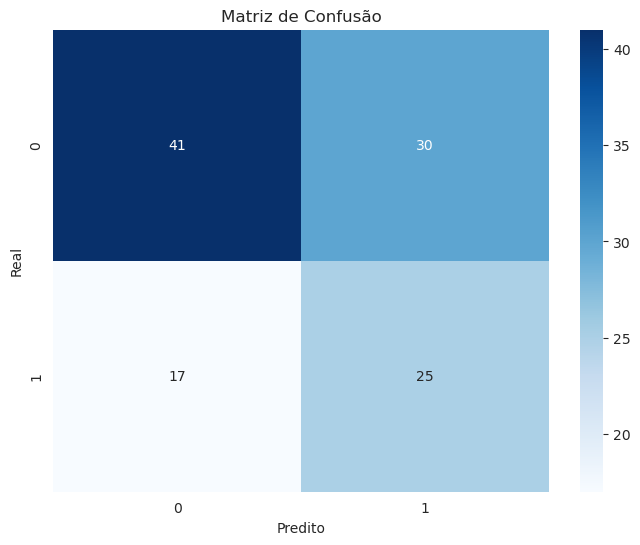


=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        71
           1       0.45      0.60      0.52        42

    accuracy                           0.58       113
   macro avg       0.58      0.59      0.58       113
weighted avg       0.61      0.58      0.59       113



In [ ]:
# Predições
y1_pred = modelo1_sklearn.predict(X1_test_scaled)
y1_pred_proba = modelo1_sklearn.predict_proba(X1_test_scaled)[:, 1]

y2_pred = modelo2_sklearn.predict(X2_test_scaled)
y2_pred_proba = modelo2_sklearn.predict_proba(X2_test_scaled)[:, 1]

y3_pred = modelo3_sklearn.predict(X3_test_scaled)
y3_pred_proba = modelo3_sklearn.predict_proba(X3_test_scaled)[:, 1]
# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y1_test, y1_pred):.4f}")
print(f"Precisão: {precision_score(y1_test, y1_pred):.4f}")
print(f"Recall: {recall_score(y1_test, y1_pred):.4f}")
print(f"F1-Score: {f1_score(y1_test, y1_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y1_test, y1_pred_proba):.4f}")

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y2_test, y2_pred):.4f}")
print(f"Precisão: {precision_score(y2_test, y2_pred):.4f}")
print(f"Recall: {recall_score(y2_test, y2_pred):.4f}")
print(f"F1-Score: {f1_score(y2_test, y2_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y2_test, y2_pred_proba):.4f}")

print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Acurácia: {accuracy_score(y3_test, y3_pred):.4f}")
print(f"Precisão: {precision_score(y3_test, y3_pred):.4f}")
print(f"Recall: {recall_score(y3_test, y3_pred):.4f}")
print(f"F1-Score: {f1_score(y3_test, y3_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y3_test, y3_pred_proba):.4f}")

# Matriz de confusão
cm = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

cm = confusion_matrix(y2_test, y2_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

cm = confusion_matrix(y3_test, y3_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()


# Relatório de classificação
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE1 === ")
print(classification_report(y1_test, y1_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE2 ===")
print(classification_report(y2_test, y2_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO - TESTE3 ===")
print(classification_report(y3_test, y3_pred))


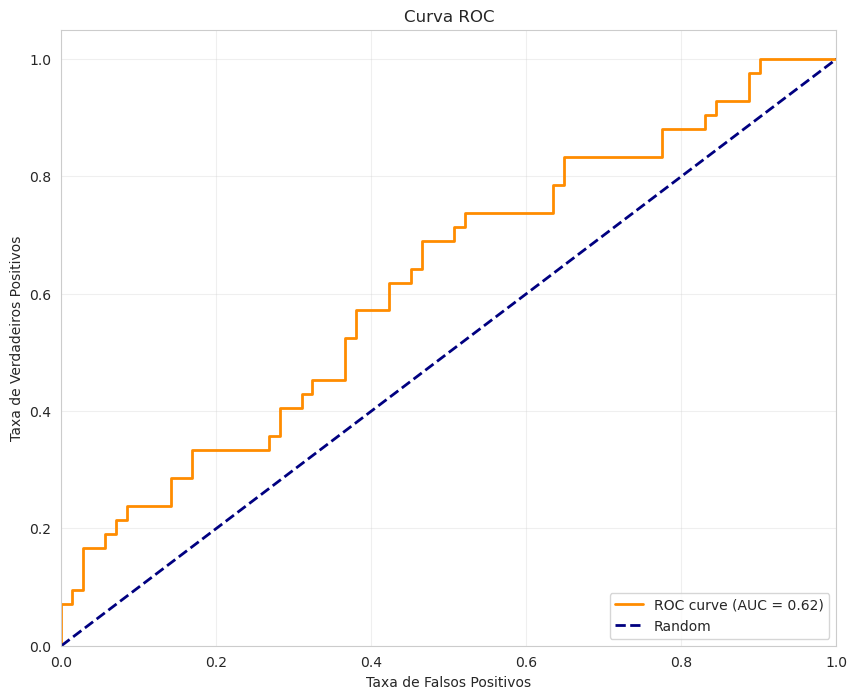

In [14]:
# Calcular ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plotar
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [15]:
# Validação cruzada (5-fold)
cv_scores = cross_val_score(modelo_sklearn, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f"ROC-AUC médio (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

ROC-AUC médio (CV): 0.7004 (+/- 0.0508)


In [16]:
from sklearn.model_selection import GridSearchCV

# Definir grid de parâmetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor ROC-AUC:", grid_search.best_score_)

# Modelo final
modelo_final = grid_search.best_estimator_

Melhores parâmetros: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Melhor ROC-AUC: 0.7004306220095693


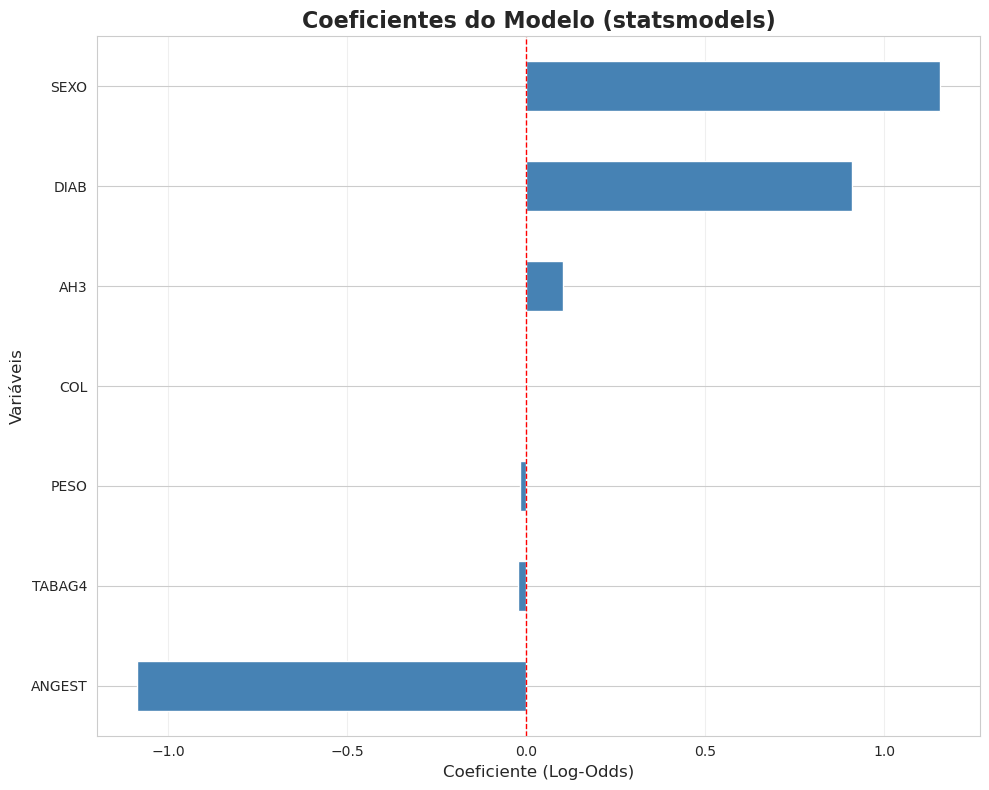

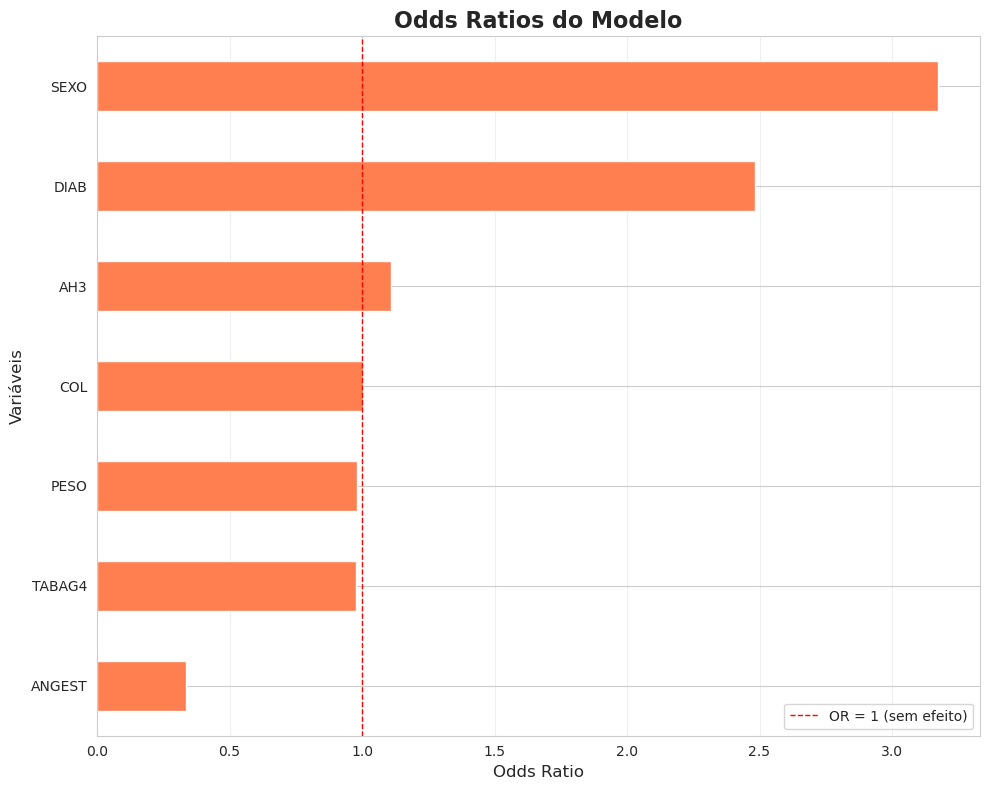

In [17]:
# Coeficientes do statsmodels
coefs_sm = resultado_sm.params[1:]  # Excluir intercept
coefs_sm_sorted = coefs_sm.sort_values()

plt.figure(figsize=(10, 8))
coefs_sm_sorted.plot(kind='barh', color='steelblue')
plt.title('Coeficientes do Modelo (statsmodels)', fontsize=16, fontweight='bold')
plt.xlabel('Coeficiente (Log-Odds)', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Odds Ratios (mais interpretável)
odds_ratios = np.exp(coefs_sm).sort_values()

plt.figure(figsize=(10, 8))
odds_ratios.plot(kind='barh', color='coral')
plt.title('Odds Ratios do Modelo', fontsize=16, fontweight='bold')
plt.xlabel('Odds Ratio', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.axvline(x=1, color='red', linestyle='--', linewidth=1, label='OR = 1 (sem efeito)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

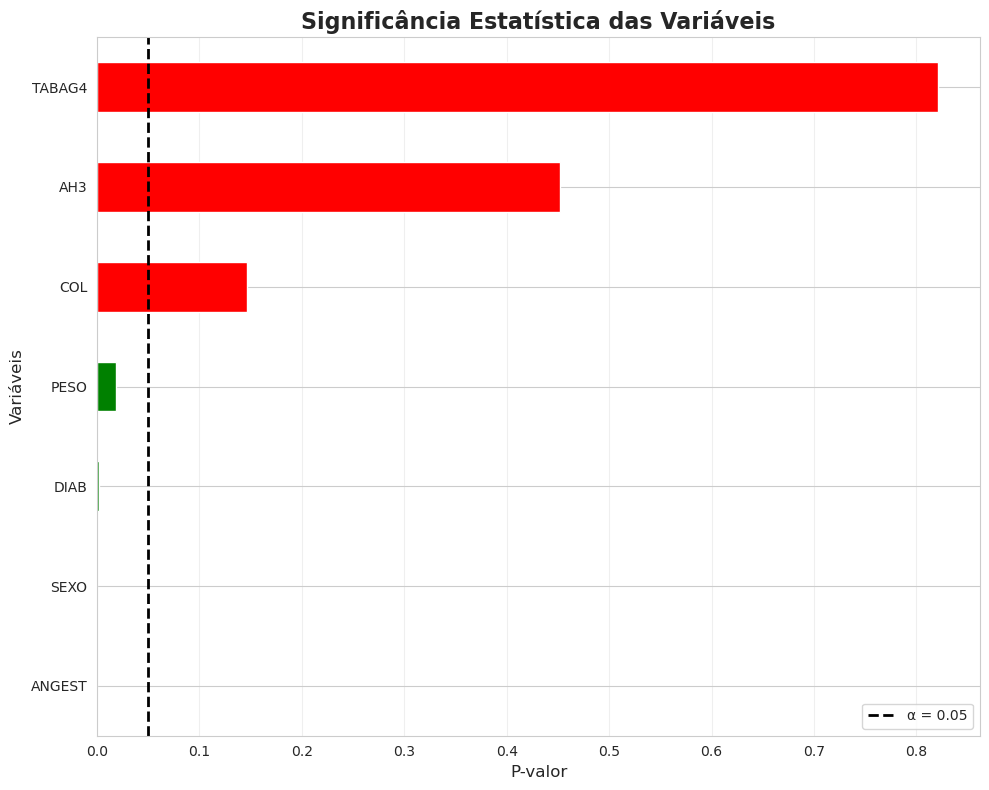

In [18]:
# P-valores com threshold de significância
p_vals = resultado_sm.pvalues[1:].sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if p < 0.05 else 'red' for p in p_vals]
p_vals.plot(kind='barh', color=colors, ax=ax)
ax.axvline(x=0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')
ax.set_xlabel('P-valor', fontsize=12)
ax.set_ylabel('Variáveis', fontsize=12)
ax.set_title('Significância Estatística das Variáveis', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

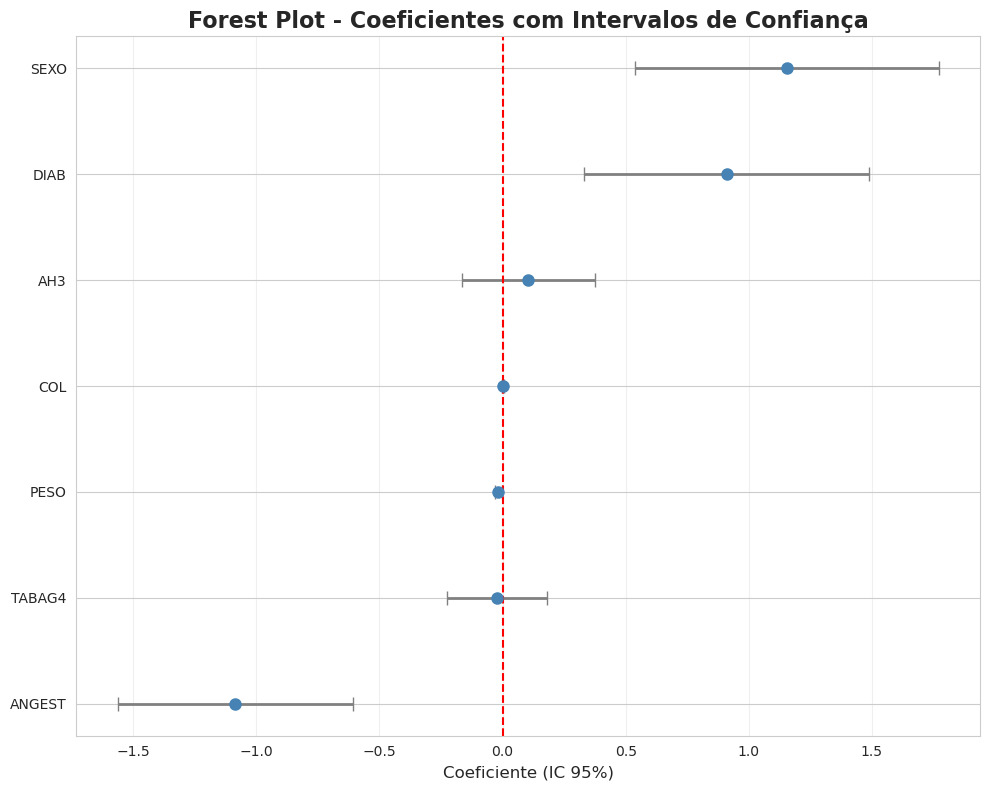

In [19]:
# Extrair coeficientes e intervalos de confiança
conf_int = resultado_sm.conf_int()
conf_int.columns = ['Lower', 'Upper']
conf_int['Coef'] = resultado_sm.params

# Remover intercept
conf_int = conf_int.iloc[1:]

# Ordenar por coeficiente
conf_int = conf_int.sort_values('Coef')

fig, ax = plt.subplots(figsize=(10, 8))

# Plot dos pontos e intervalos
y_pos = np.arange(len(conf_int))
ax.errorbar(conf_int['Coef'], y_pos, 
            xerr=[conf_int['Coef'] - conf_int['Lower'], 
                  conf_int['Upper'] - conf_int['Coef']],
            fmt='o', color='steelblue', ecolor='gray', 
            elinewidth=2, capsize=5, markersize=8)

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(conf_int.index)
ax.set_xlabel('Coeficiente (IC 95%)', fontsize=12)
ax.set_title('Forest Plot - Coeficientes com Intervalos de Confiança', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

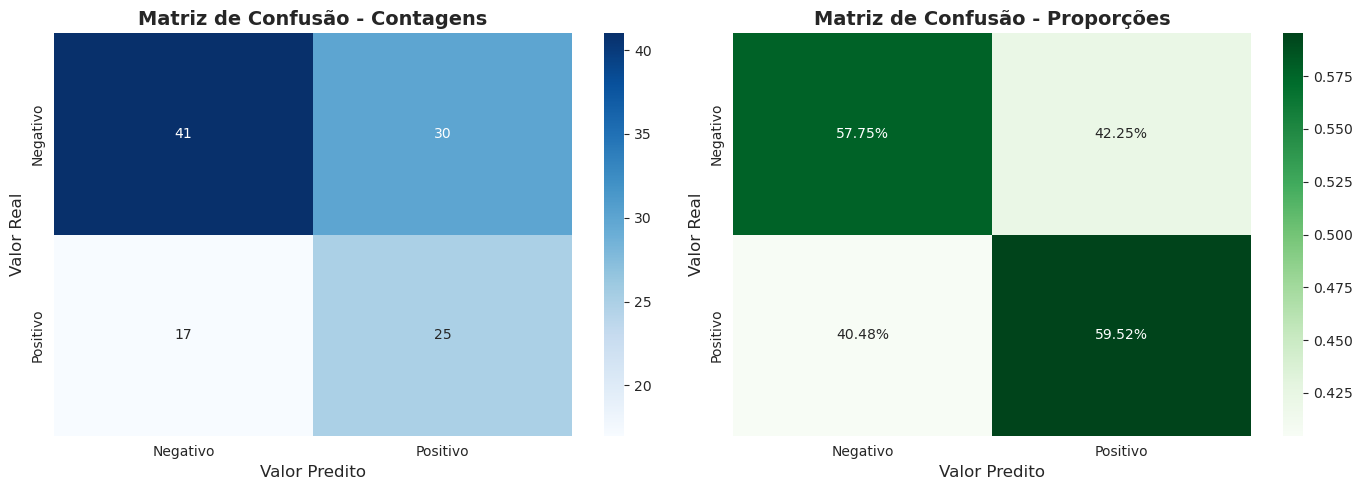


📊 Métricas da Matriz de Confusão:
   Verdadeiros Negativos (TN): 41
   Falsos Positivos (FP): 30
   Falsos Negativos (FN): 17
   Verdadeiros Positivos (TP): 25
   Taxa de Erro: 41.59%


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predições
y_pred = modelo_sklearn.predict(X_test_scaled)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualização estilo 1: Seaborn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contagens absolutas
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0],
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
axes[0].set_title('Matriz de Confusão - Contagens', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=12)
axes[0].set_xlabel('Valor Predito', fontsize=12)

# Proporções
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', cbar=True, ax=axes[1],
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
axes[1].set_title('Matriz de Confusão - Proporções', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=12)
axes[1].set_xlabel('Valor Predito', fontsize=12)

plt.tight_layout()
plt.show()

# Adicionar métricas na matriz
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Métricas da Matriz de Confusão:")
print(f"   Verdadeiros Negativos (TN): {tn}")
print(f"   Falsos Positivos (FP): {fp}")
print(f"   Falsos Negativos (FN): {fn}")
print(f"   Verdadeiros Positivos (TP): {tp}")
print(f"   Taxa de Erro: {(fp + fn) / (tn + fp + fn + tp):.2%}")

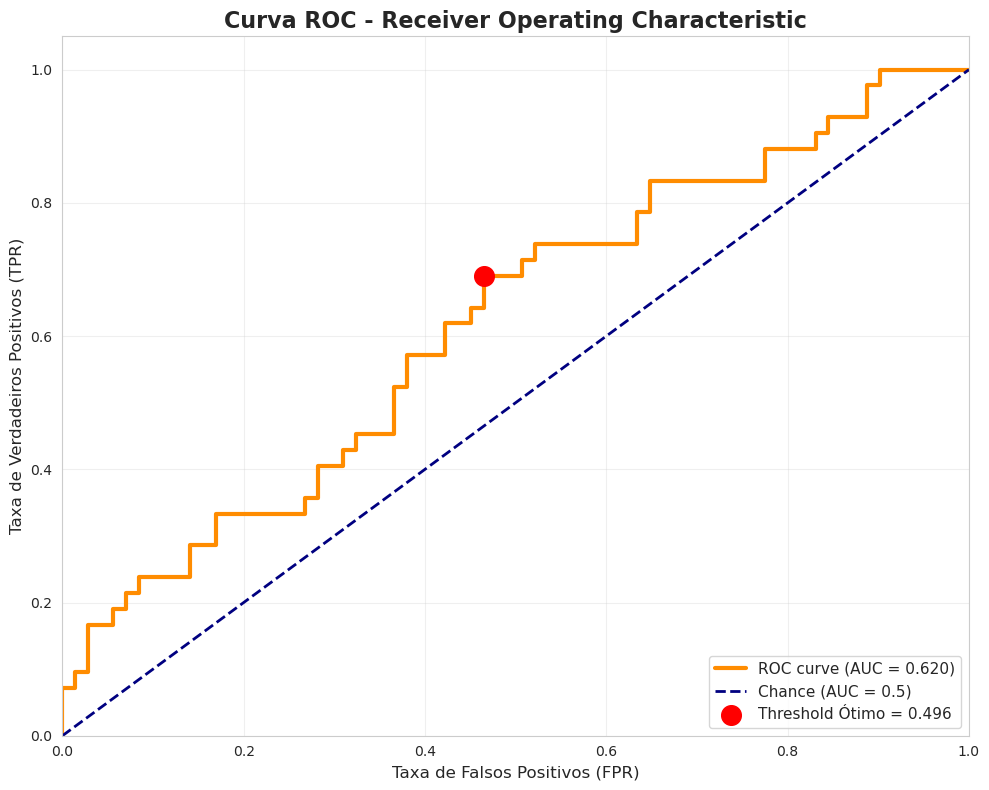

🎯 Threshold Ótimo: 0.4962
   TPR no ponto ótimo: 0.690
   FPR no ponto ótimo: 0.465


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular curva ROC
y_pred_proba = modelo_sklearn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Encontrar threshold ótimo (Youden's Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

fig, ax = plt.subplots(figsize=(10, 8))

# Plotar curva ROC
ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.5)')

# Marcar ponto ótimo
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=200, 
           label=f'Threshold Ótimo = {optimal_threshold:.3f}', zorder=5)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
ax.set_title('Curva ROC - Receiver Operating Characteristic', fontsize=16, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"🎯 Threshold Ótimo: {optimal_threshold:.4f}")
print(f"   TPR no ponto ótimo: {tpr[optimal_idx]:.3f}")
print(f"   FPR no ponto ótimo: {fpr[optimal_idx]:.3f}")

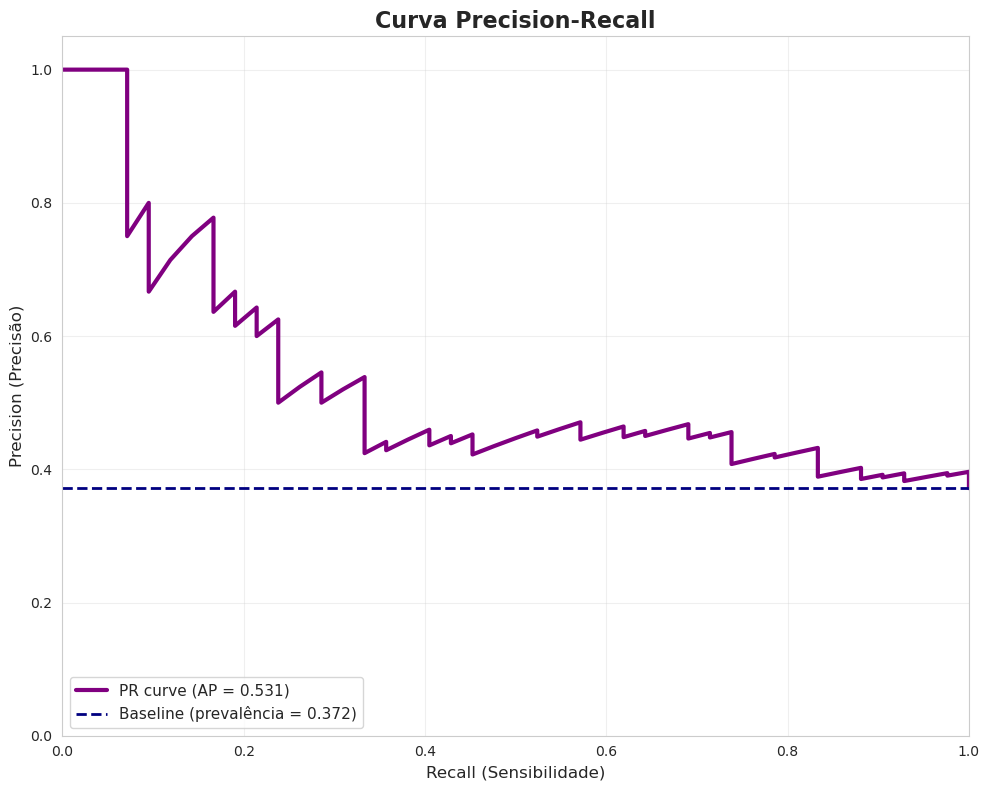

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular curva Precision-Recall
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall, precision, color='purple', lw=3, label=f'PR curve (AP = {avg_precision:.3f})')
ax.axhline(y=y_test.mean(), color='navy', linestyle='--', lw=2, 
           label=f'Baseline (prevalência = {y_test.mean():.3f})')

ax.set_xlabel('Recall (Sensibilidade)', fontsize=12)
ax.set_ylabel('Precision (Precisão)', fontsize=12)
ax.set_title('Curva Precision-Recall', fontsize=16, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

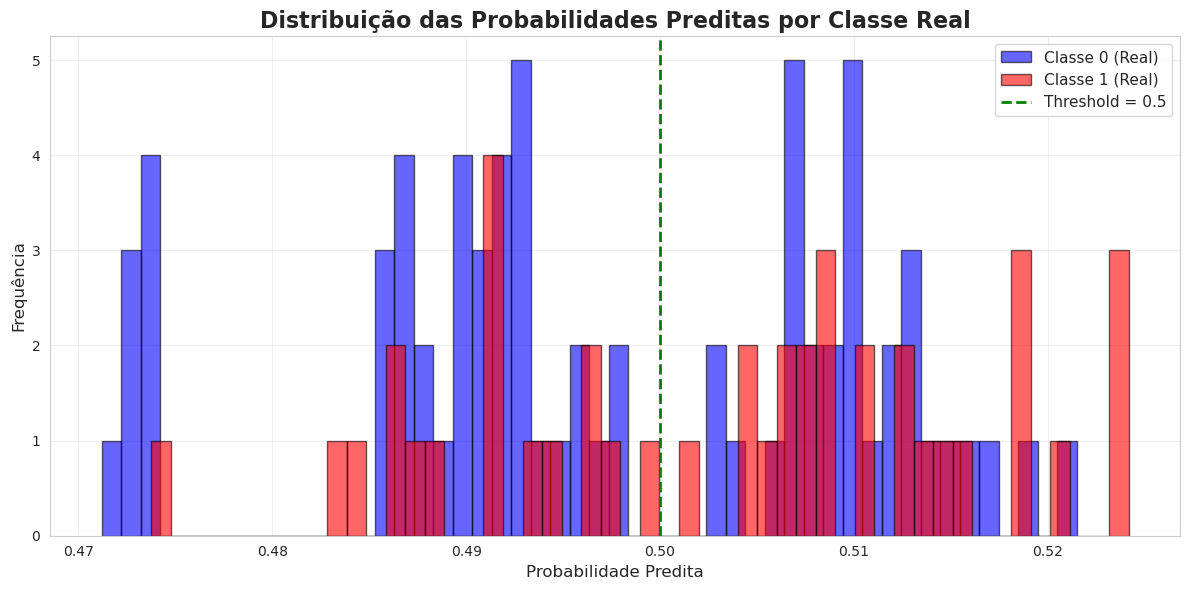

In [23]:
# Separar probabilidades por classe real
probs_class_0 = y_pred_proba[y_test == 0]
probs_class_1 = y_pred_proba[y_test == 1]

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(probs_class_0, bins=50, alpha=0.6, color='blue', label='Classe 0 (Real)', edgecolor='black')
ax.hist(probs_class_1, bins=50, alpha=0.6, color='red', label='Classe 1 (Real)', edgecolor='black')
ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Threshold = 0.5')

ax.set_xlabel('Probabilidade Predita', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.set_title('Distribuição das Probabilidades Preditas por Classe Real', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

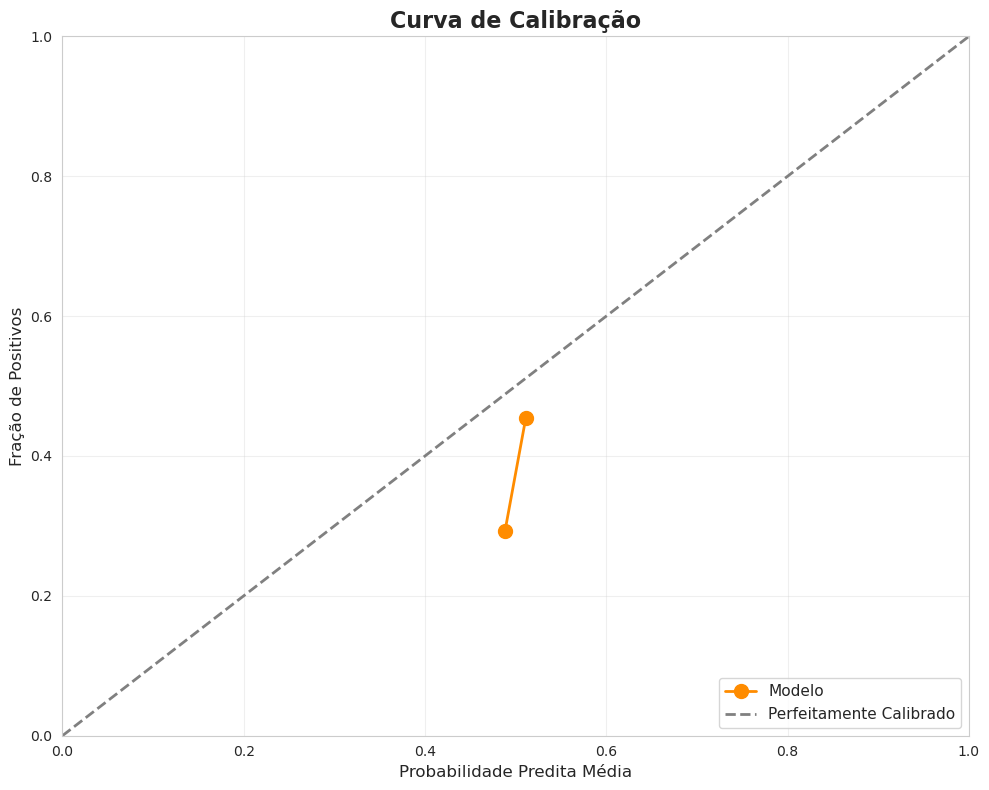

In [24]:
from sklearn.calibration import calibration_curve

# Calcular curva de calibração
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(10, 8))

# Plotar calibração
ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Modelo', color='darkorange', markersize=10)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfeitamente Calibrado', linewidth=2)

ax.set_xlabel('Probabilidade Predita Média', fontsize=12)
ax.set_ylabel('Fração de Positivos', fontsize=12)
ax.set_title('Curva de Calibração', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
plt.tight_layout()
plt.show()

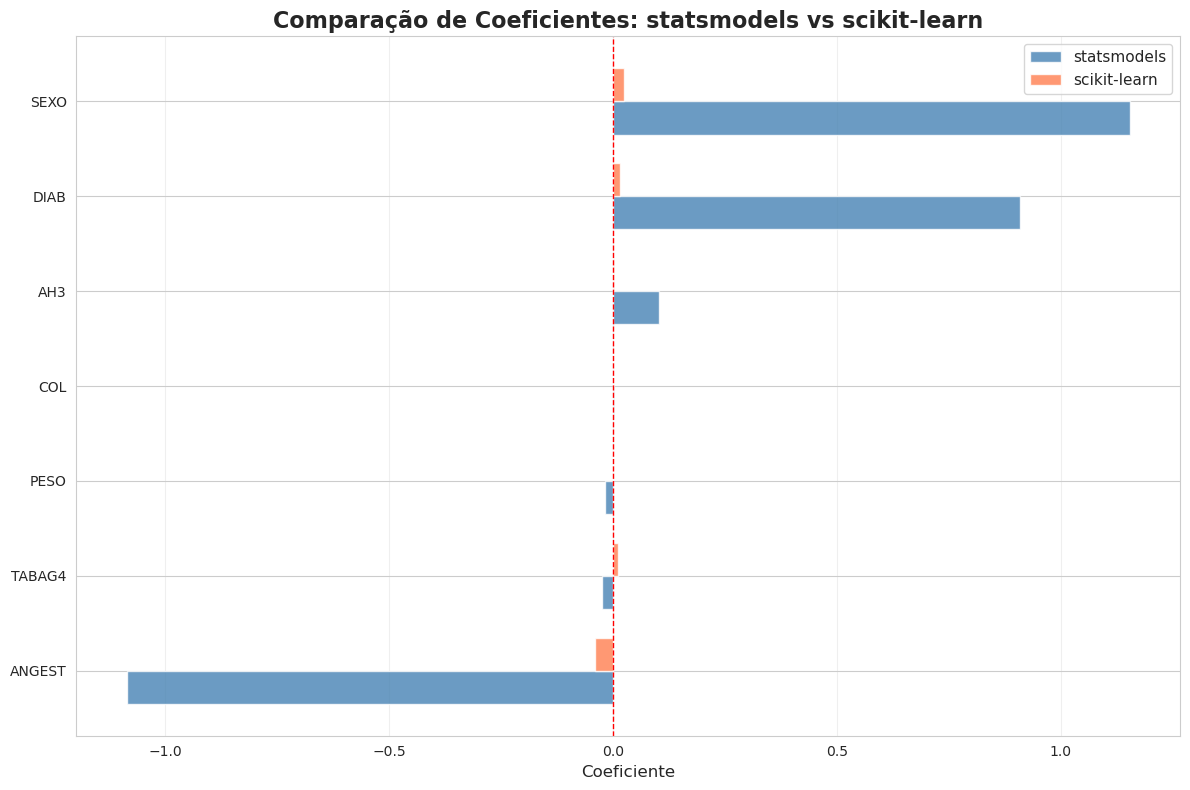

In [25]:
# Comparar coeficientes entre os dois modelos
# Certifique-se de que as variáveis estão na mesma ordem

# Para statsmodels
coefs_sm_df = pd.DataFrame({
    'Variavel': resultado_sm.params.index[1:],
    'Coef_statsmodels': resultado_sm.params.values[1:]
})

# Para scikit-learn
coefs_sklearn_df = pd.DataFrame({
    'Variavel': X_train.columns,
    'Coef_sklearn': modelo_sklearn.coef_[0]
})

# Merge
comparison = pd.merge(coefs_sm_df, coefs_sklearn_df, on='Variavel', how='inner')
comparison = comparison.sort_values('Coef_statsmodels')

# Plot comparativo
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(comparison))
width = 0.35

bars1 = ax.barh(x - width/2, comparison['Coef_statsmodels'], width, 
                label='statsmodels', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, comparison['Coef_sklearn'], width, 
                label='scikit-learn', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison['Variavel'])
ax.set_xlabel('Coeficiente', fontsize=12)
ax.set_title('Comparação de Coeficientes: statsmodels vs scikit-learn', 
             fontsize=16, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

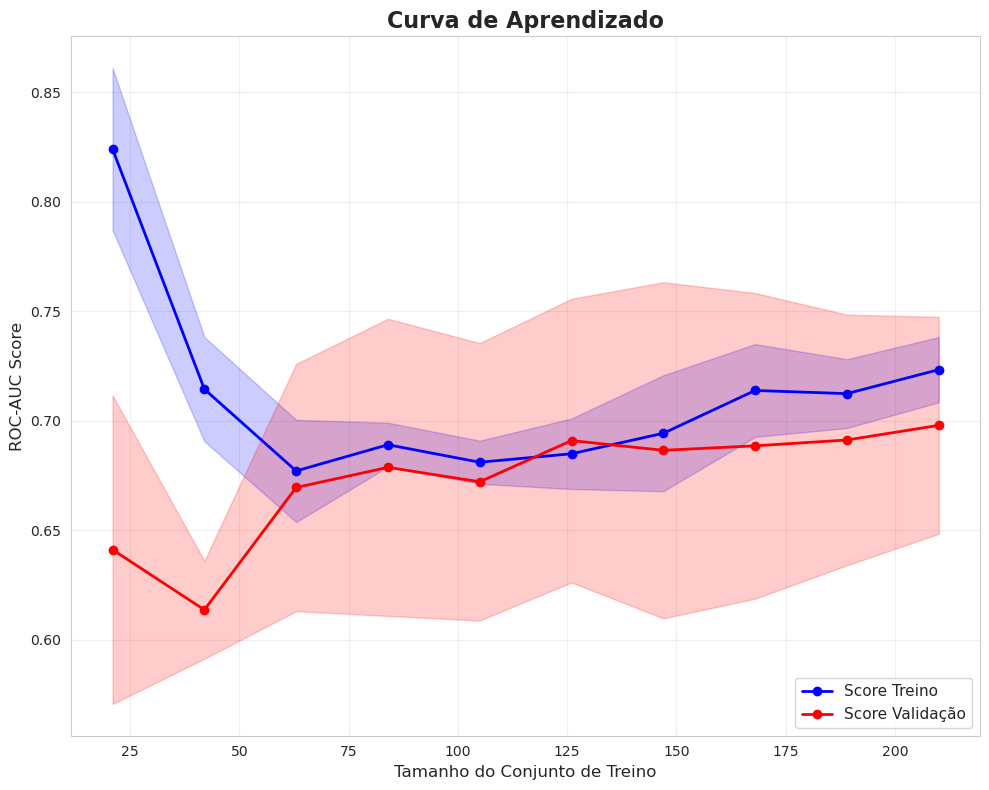

In [26]:
from sklearn.model_selection import learning_curve

# Calcular learning curve
train_sizes, train_scores, val_scores = learning_curve(
    modelo_sklearn, X_train_scaled, y_train, 
    cv=5, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='roc_auc'
)

# Calcular médias e desvios
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot treino
ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Score Treino', linewidth=2)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                alpha=0.2, color='blue')

# Plot validação
ax.plot(train_sizes, val_mean, 'o-', color='red', label='Score Validação', linewidth=2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                alpha=0.2, color='red')

ax.set_xlabel('Tamanho do Conjunto de Treino', fontsize=12)
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Curva de Aprendizado', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

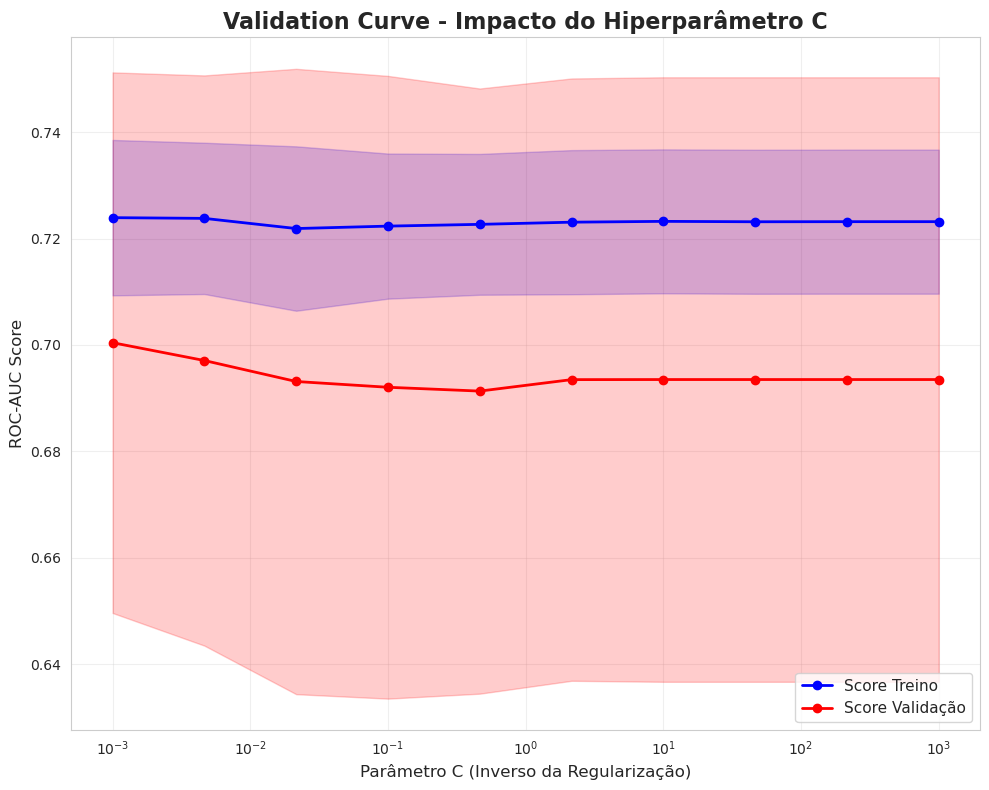

In [27]:
from sklearn.model_selection import validation_curve

# Testar diferentes valores de C
param_range = np.logspace(-3, 3, 10)

train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_scaled, y_train,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

ax.semilogx(param_range, train_mean, 'o-', color='blue', label='Score Treino', linewidth=2)
ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                alpha=0.2, color='blue')

ax.semilogx(param_range, val_mean, 'o-', color='red', label='Score Validação', linewidth=2)
ax.fill_between(param_range, val_mean - val_std, val_mean + val_std, 
                alpha=0.2, color='red')

ax.set_xlabel('Parâmetro C (Inverso da Regularização)', fontsize=12)
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Validation Curve - Impacto do Hiperparâmetro C', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# ATENÇÃO: Funciona apenas com 2 variáveis preditoras
# Exemplo: se você tem apenas idade e renda

def plot_decision_boundary(X, y, model, feature_names):
    """
    Plota a fronteira de decisão para modelo com 2 features
    """
    if X.shape[1] != 2:
        print("⚠️  Decision Boundary só funciona com exatamente 2 features!")
        return
    
    # Criar grid
    h = 0.02  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predizer em todo o grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Contour
    contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)
    
    # Scatter dos pontos
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                        edgecolors='black', s=100, alpha=0.7)
    
    ax.set_xlabel(feature_names[0], fontsize=12)
    ax.set_ylabel(feature_names[1], fontsize=12)
    ax.set_title('Fronteira de Decisão da Regressão Logística', fontsize=16, fontweight='bold')
    
    # Legenda
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend1)
    
    plt.colorbar(contour, ax=ax, label='Classe Predita')
    plt.tight_layout()
    plt.show()

# Exemplo de uso (SE você tiver apenas 2 features):
# X_2d = X_train_scaled[:, [0, 1]]  # Selecionar 2 features
# plot_decision_boundary(X_2d, y_train, modelo_sklearn, ['Feature 1', 'Feature 2'])

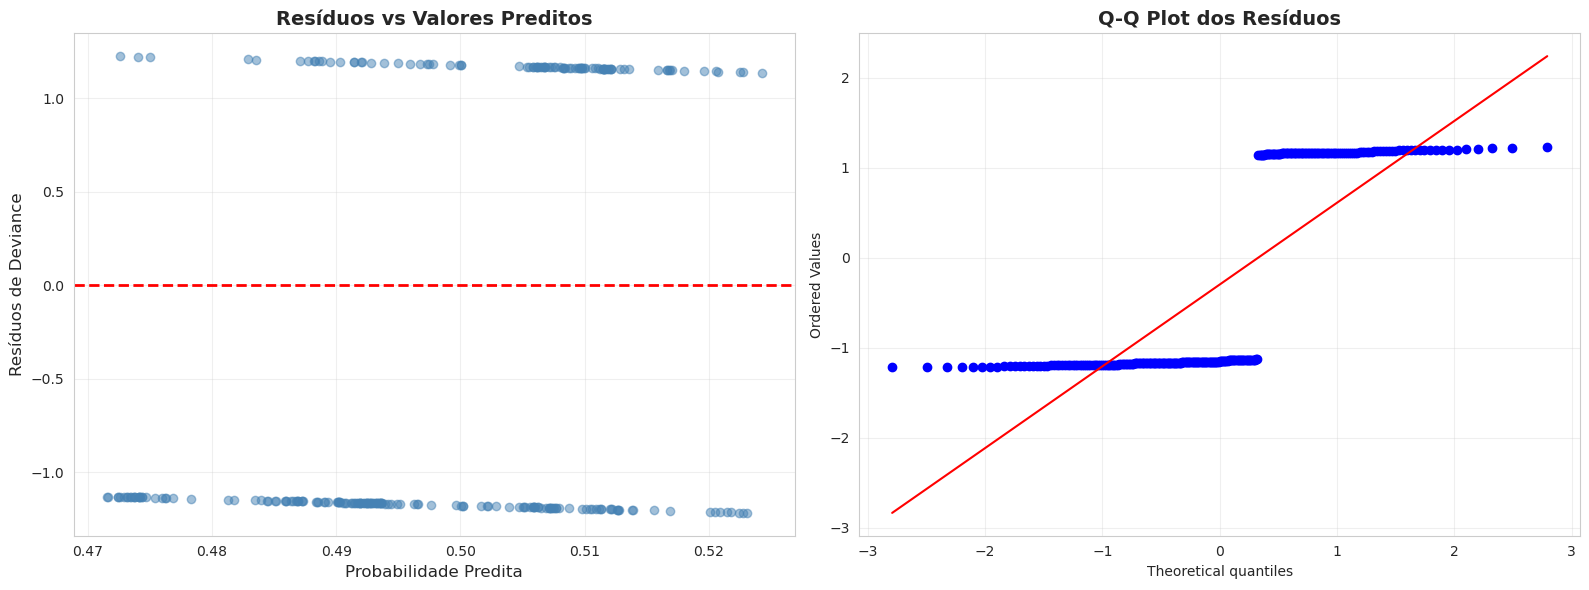

In [29]:
# Resíduos para regressão logística
y_pred_proba_train = modelo_sklearn.predict_proba(X_train_scaled)[:, 1]

# Resíduos de deviance
residuals = np.where(y_train == 1, 
                     np.sqrt(-2 * np.log(y_pred_proba_train)),
                     np.sqrt(-2 * np.log(1 - y_pred_proba_train)))
residuals = np.where(y_train == 1, residuals, -residuals)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Resíduos vs Valores Preditos
axes[0].scatter(y_pred_proba_train, residuals, alpha=0.5, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Probabilidade Predita', fontsize=12)
axes[0].set_ylabel('Resíduos de Deviance', fontsize=12)
axes[0].set_title('Resíduos vs Valores Preditos', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot dos Resíduos', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

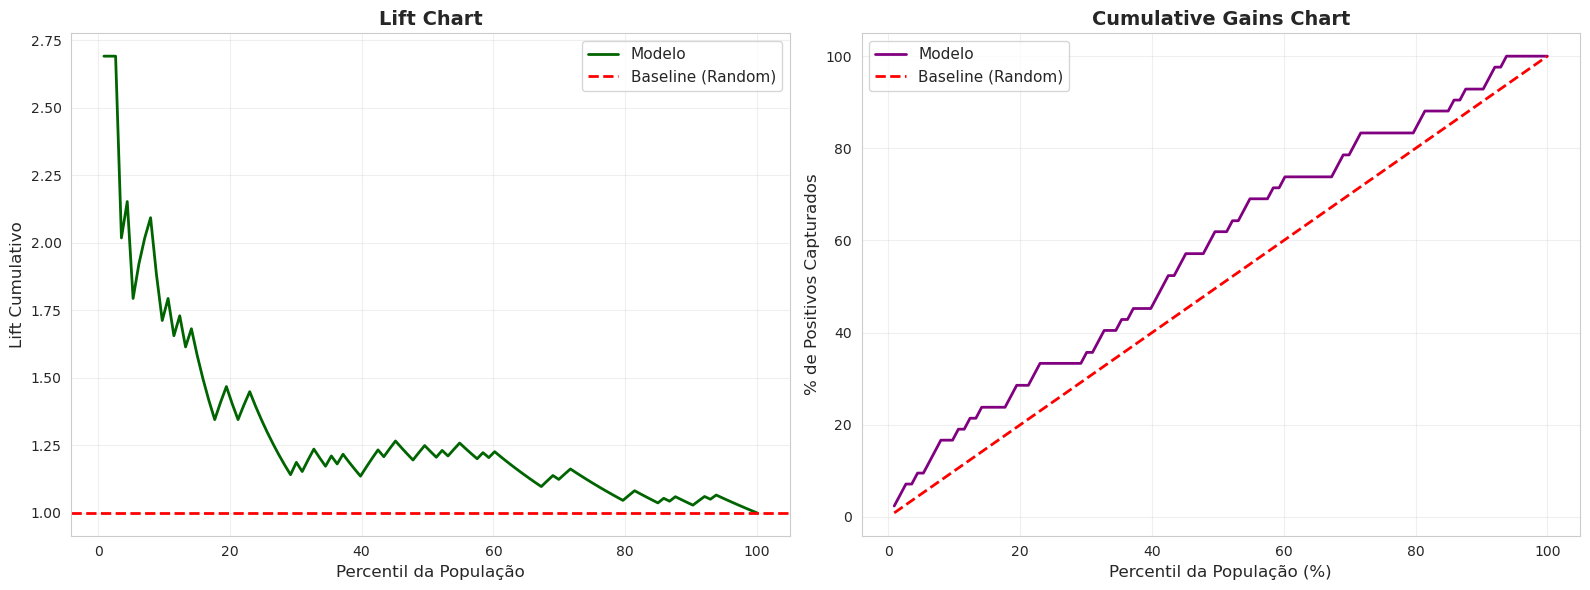

In [30]:
from sklearn.metrics import precision_recall_curve

# Ordenar predições
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.iloc[sorted_indices].values
y_pred_sorted = y_pred_proba[sorted_indices]

# Calcular lift cumulativo
cumulative_actual = np.cumsum(y_test_sorted)
cumulative_baseline = np.arange(1, len(y_test_sorted) + 1) * y_test.mean()
lift = cumulative_actual / cumulative_baseline

# Percentis
percentiles = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lift Chart
axes[0].plot(percentiles, lift, linewidth=2, color='darkgreen', label='Modelo')
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Random)')
axes[0].set_xlabel('Percentil da População', fontsize=12)
axes[0].set_ylabel('Lift Cumulativo', fontsize=12)
axes[0].set_title('Lift Chart', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Cumulative Gains Chart
axes[1].plot(percentiles, cumulative_actual / cumulative_actual[-1] * 100, 
             linewidth=2, color='purple', label='Modelo')
axes[1].plot(percentiles, percentiles, linestyle='--', color='red', linewidth=2, 
             label='Baseline (Random)')
axes[1].set_xlabel('Percentil da População (%)', fontsize=12)
axes[1].set_ylabel('% de Positivos Capturados', fontsize=12)
axes[1].set_title('Cumulative Gains Chart', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()